# MIE 1624- Introduciton to Data Science and Analytics
# Assignment 2- Sentiment Analysis

#### Syed Hamdan Mustafa 
#### 1006193209

The whole code takes about 100 minutes to run. KNN takes the longest time (around 45 minutes for both the types of features) whereas the Neural networks also take 45 minutes to run. Comment those sections out for a quicker run. KNN is Section- 4.1.4 and 4.2.4

Note that Neural networks are just done as an addition (bonus) and they were not included in the Model Results (in Section 5). This was just to experiment using Deep Learning and understanding the different complexities involved in working with them.

The sections understood to be as Bonus has been labelled as such in the different sections.

Install relevant libraries

In [1]:
!pip install numpy
!pip install pandas
!pip install sklearn
!pip install wordcloud
!pip install xgboost

In [2]:
# Importing required libraries
import pandas as pd
import numpy as np
from collections import Counter, OrderedDict
import operator
import re
import nltk
from nltk.corpus import stopwords
from scipy.stats import randint

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Download resources
nltk.download('stopwords')

# Custom settings to view all column names and their data in the output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

import warnings
warnings.filterwarnings('ignore') #ignore warnings

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\syedh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Reading Data

In [3]:
#Generic tweets file
df_generic = pd.read_csv('generic_tweets.txt', sep=",")
df_generic.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [4]:
#Elections tweets file
df_elections = pd.read_csv('Canadian_elections_2019.csv', sep=",")
df_elections.head()

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, how about we agree that #Canadian #women can not and should not trust that #AndrewScheer and a #Conservatives government will protect a woman's right to have automony over her body. Let's go with that. #cdnpoli #elxn43 #Canada #abortion"""
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Station \n#EtobicokeNorth #CityofTO #ONPoli #cdnpoli #elxn43 https://t.co/wgdXLksTbQ"""
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLION FOR THE NEXT 4 YEARS! ASK JUSTIN! #elxn43 #cdnpoli #Canada https://t.co/9DTLLd9972"""
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#elxn43 \n\nCan't decide? This should help!\n\nhttps://t.co/UNe5J1tDJ6"""
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of having their hard earned $ donated to corporate welfare bums that don't need it! This is only one of many reasons #TrudeauMustGo. @SNCLavalin can leave #Canada for all I care. @Sheila_Copps #SNCLavalinScandal #Election2019 #elxn43 #cdnpoli https://t.co/ywD7MAByKk"""


## 1- Data Cleaning

The generic tweets and election tweets were cleaned to satisfy the following conditions:
- All html tags and attributes (i.e., /<[^>]+>/) are removed.
- Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
- All URLs are removed.
- All characters in the text are in lowercase.
- All stop words are removed. Be clear in what you consider as a stop word.
- If a tweet is empty after pre-processing, it should be preserved as such.

In [5]:
def TweetsCleaning (df_preprocessing):
    """This function is used to clean the tweets file"""
    
    #Step 1- Lower case all the tweets
    df_preprocessing.loc[:,'text_lower'] = df_preprocessing["text"].apply(lambda x: x.lower()).copy()
    
    #Step 2- Remove hastags, urls and mentions
    df_preprocessing.loc[:,'text_lower_without_hastags_mentions_urls']=df_preprocessing["text_lower"].apply(lambda x:re.sub('(@[\w]+)|(^rt\s+)|(http[s]:\/\/[\w\.-\/]+[\s]*)|(http:\/\/[\w\.-\/]+[\s]*)|(#)',' ',x))
    
    #Step 3- Remove punctuations and special characters
    df_preprocessing.loc[:,'text_lower_without_hastags_mentions_urls_punct']=df_preprocessing["text_lower_without_hastags_mentions_urls"].apply(lambda x:re.sub('([^\w]+)',' ',x))
    
    #Step 4- Remove stopwords                                           
    stop_words=stopwords.words("english")+ ['retweeted','retweet','rt','cdnpoli' ,'elxn43','cdnelxn2019','n','cndpoli']
    df_preprocessing.loc[:,"text_lower_without_hastags_mentions_urls_punct_stopwords"]=df_preprocessing["text_lower_without_hastags_mentions_urls_punct"].apply(lambda x: str(" ".join(x for x in x.split() if x not in stop_words)))
    
    #Step 5- Remove emojis
    df_preprocessing.loc[:,"text_lower_without_hastags_mentions_urls_punct_stopwords_emojis"]= df_preprocessing["text_lower_without_hastags_mentions_urls_punct_stopwords"].apply(lambda x:re.sub('(\s)x\w+|xe2',' ',x))
                                                                                                                            
    return df_preprocessing                                                                                                                       

### 1.1- Cleaning the generic tweets file

In [6]:
#Cleaning the generic tweets
df_clean= TweetsCleaning(df_generic[["text"]])

In [7]:
#Replacing the cleaned text in the main dataframe
df_generic['text']= df_clean.iloc[:,-1]
df_generic.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result school today also blah
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see


### 1.2- Cleaning the elections tweets file

The same cleaning function was used to clean the elections file. In addition, it was noticed that these elections started with a 'b' and hence an additional cleaning step was included for this.

In [8]:
#Removing the 'b' in the beginning of each election tweet
if df_elections['text'].str[0][0]== "b":
    df_elections["text"] = df_elections['text'].str[1:]

In [9]:
#Cleaning the elections tweets
df_clean= TweetsCleaning(df_elections[["text"]])

In [10]:
#Replacing the cleaned text in the main dataframe
df_elections['text']= df_clean.iloc[:,-1]
df_elections.head()

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,instead suggestion agree canadian women trust andrewscheer conservatives government protect woman right automony body let go canada abortion
1,positive,NaN,allwomanspacewalk real etobicokenorth cityofto onpoli
2,negative,Economy,brantford going cost 94 billion next 4 years ask justin canada
3,positive,NaN,canada canadaelection2019 canadavotes ncan decide help
4,negative,Economy,canada taxpayers sick amp tired hard earned donated corporate welfare bums need one many reasons trudeaumustgo leave canada care snclavalinscandal election2019


## 2- Data Exploration

### 2.1 Classification of tweets for the election parties

A function was created to classify the tweets based on keywords for the three parties. The keywords were entered using research and using the word clouds generated later.

The first step is to classify the tweets for each party and develop a count chart.

In [11]:
def classify_tweets(tweet):
    """This function is used to classify the tweets for the three parties"""

    #Defining key words for each party
    liberal =['trudeau', "justin", "justintrudeau","black face","blackface" "liberal","liberals","lib","realchange","red","teamtrudeau","lpc","real change","chooseforward"] #defining parties
    conservative=["andrew", "sheer", "conservative","schear","blue", "conservatives","cpc","protect our economy","us passport"]
    NDP=["ndp","orange","in it for you","ready4change","jagmeet","singh","turban","national democratic party"]
    other = ["green","freedom","bloc","quebecois", "may", "bernier","elizabeth"]

    # we only defined words in lowercase format, since all words in tweet line are converted to lowercase

    party = []
    for word in liberal:   
        if word in tweet:
            party.append('Liberal')

    for word in conservative:
         if word in tweet:
            party.append('Conservative')

    for word in NDP:
         if word in tweet:
            party.append('NDP')

    for word in other:
         if word in tweet:
            party.append('Other')

    #choose the most common party name for this tweet since there could be more than one classification for the same tweet
    if len(party) > 1:
        most_common = max(set(party), key=party.count)
        party = []
        party.append(most_common)
    elif len(party) == 0:
        party.append('Other')
    
    return party 

In [12]:
#Looping over all the canadian elections tweet text
tweets_total= []
other_tweet, conservative_tweet, liberal_tweet, ndp_tweet= [],[],[],[]
liberal_index, conservative_index, ndp_index= [],[],[]

for i in range(df_elections["text"].shape[0]):
    tweet_party= classify_tweets(df_elections["text"][i])[0]
    tweets_total.append(tweet_party)
    
    #Saving the tweets for each party for further investigation
    #Note that we are also saving the indexes for the respective tweets. This will come in handy later.
    if tweet_party=="Other":
        other_tweet.append(df_elections["text"][i])
    if tweet_party=="Liberal":
        liberal_tweet.append(df_elections["text"][i])
        liberal_index.append(i)
    if tweet_party=="Conservative":
        conservative_tweet.append(df_elections["text"][i])
        conservative_index.append(i)
    if tweet_party=="NDP":
        ndp_tweet.append(df_elections["text"][i])
        ndp_index.append(i)

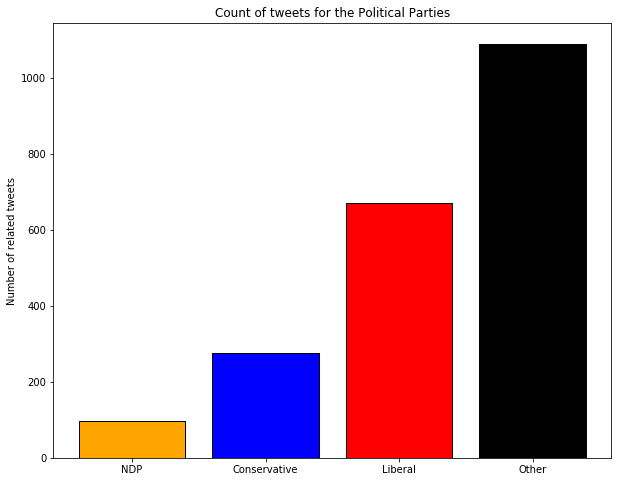

In [13]:
#Using the operator and collections library to sort the dict values in ascending order of count of tweets
tweets_dict= OrderedDict(sorted(Counter(tweets_total).items(), key=operator.itemgetter(1)))

y= tweets_dict.values()
x= tweets_dict.keys()

plt.figure(figsize=(10, 8))
plt.bar(x,y,edgecolor="black",linewidth=1, color=['orange', 'blue', 'red', 'black'])
plt.ylabel("Number of related tweets")
plt.title("Count of tweets for the Political Parties")
plt.show()

As it can be seen, Liberals were mentioned amongst the most times compared to the other two parties. Note that this has nothing to do with the sentiment of the tweets for now. These are just the count each party were mentioned.
The Other tweets indicate tweets that could not be classified because they did not contain any of the keywords for the three major parties.

### 2.2- Graphical Representation of Tweets

In [14]:
def convert_tweets_to_words (tweet):
    """This function converts sentences into a list of words"""
    words=[]    
    for sentence in tweet:
        wordList = re.sub("[^\w]", " ",  sentence).split() #converts each tweet into a list of words (creates a nested list)
        words.append(wordList)
    words= [item for sublist in words for item in sublist] #converts nested list into a 1D list to ease future implementation    
        
    return words

#### 2.2.1 Generic Tweets

Lets generate a wordcloud for the generic tweets to see what is being said there.

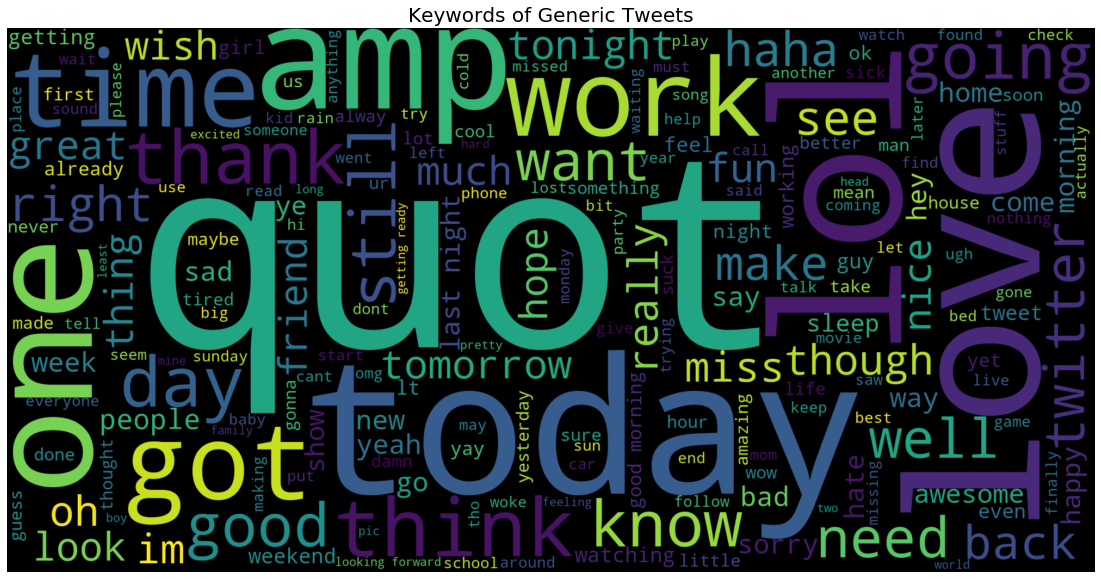

In [15]:
gen= convert_tweets_to_words(df_generic["text"])
gen_str = ' '.join(gen)
wordcloud = WordCloud(width = 2000, height = 1000).generate(gen_str)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Generic Tweets', fontsize= 20)
plt.axis("off")
plt.show()

Interesting. love, lol and today seem to jump out but they are mostly random words that do not provide a lot of insights.

Lets look at the sentiments distribution for the generic tweets.

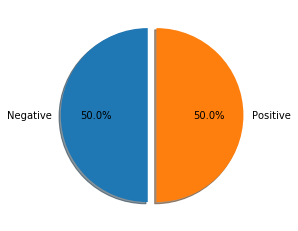

Number of generic tweets: 200000


In [16]:
labels = "Negative", "Positive"
explode = (0, 0.1) 
plt.pie(Counter(df_generic["class"]).values(), explode= explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
plt.show()
print("Number of generic tweets:", len(df_generic["class"]))

Looks like we have a good balanced distribution of Positive and negative sentiments in the tweets. There is also a large amount of data available for both cases that should help train the model better.

#### 2.2.1- Canadian Elections Tweets

Whats being tweeted about the 3 major parties? Lets use word cloud to find out.
Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points can be highlighted using a word cloud. Word clouds are widely used for analyzing data from social network websites.

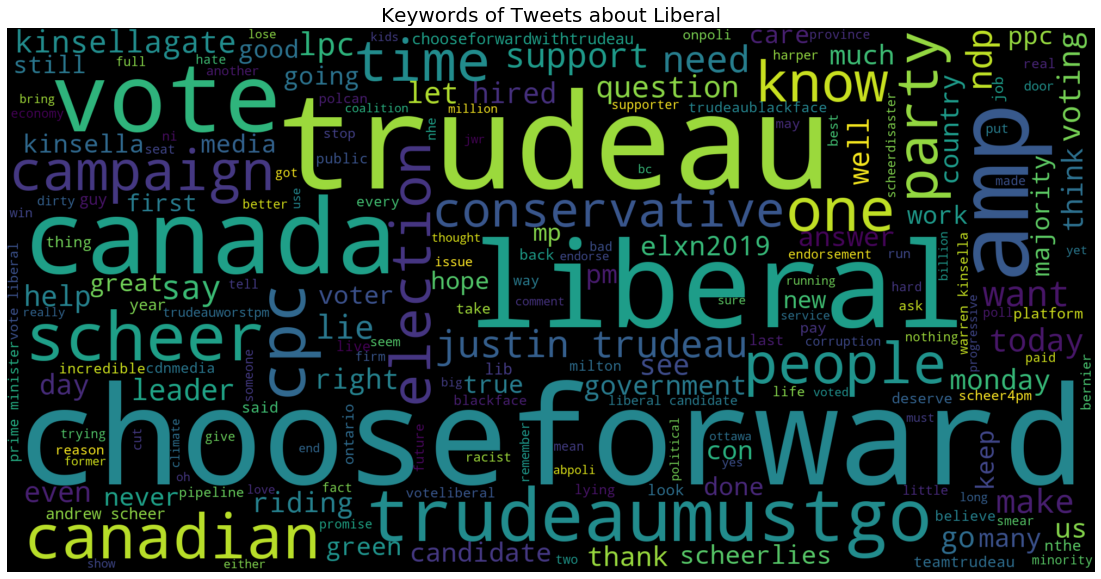

In [17]:
lib= convert_tweets_to_words(liberal_tweet)
lib_str = ' '.join(lib)
wordcloud = WordCloud(width = 2000, height = 1000).generate(lib_str)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Tweets about Liberal', fontsize= 20)
plt.axis("off")
plt.show()

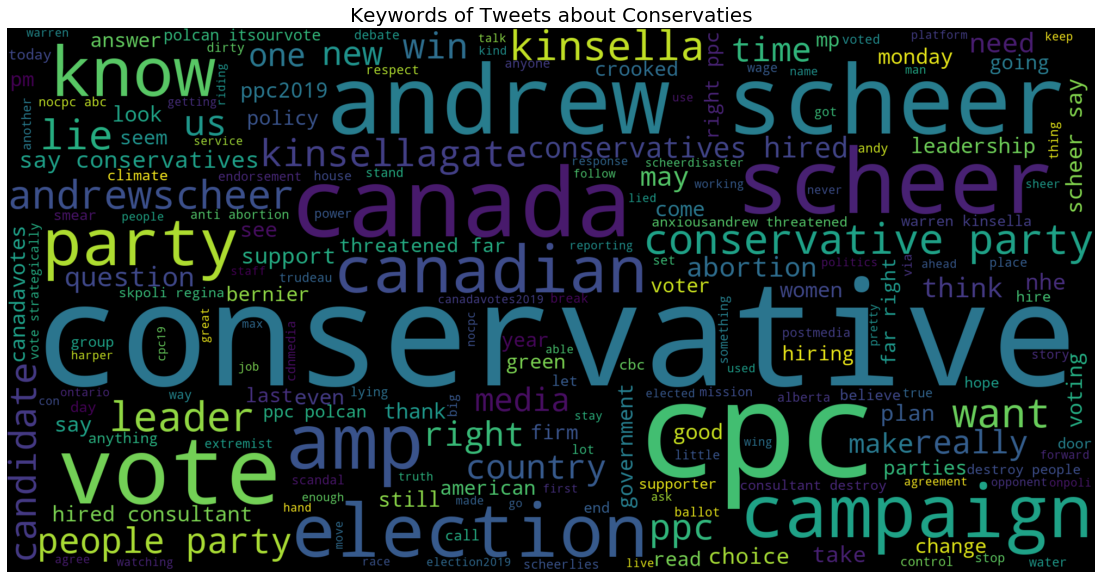

In [18]:
conv= convert_tweets_to_words(conservative_tweet)
conv_str = ' '.join(conv)
wordcloud = WordCloud(width = 2000, height = 1000).generate(conv_str)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Tweets about Conservaties', fontsize= 20)
plt.axis("off")
plt.show()

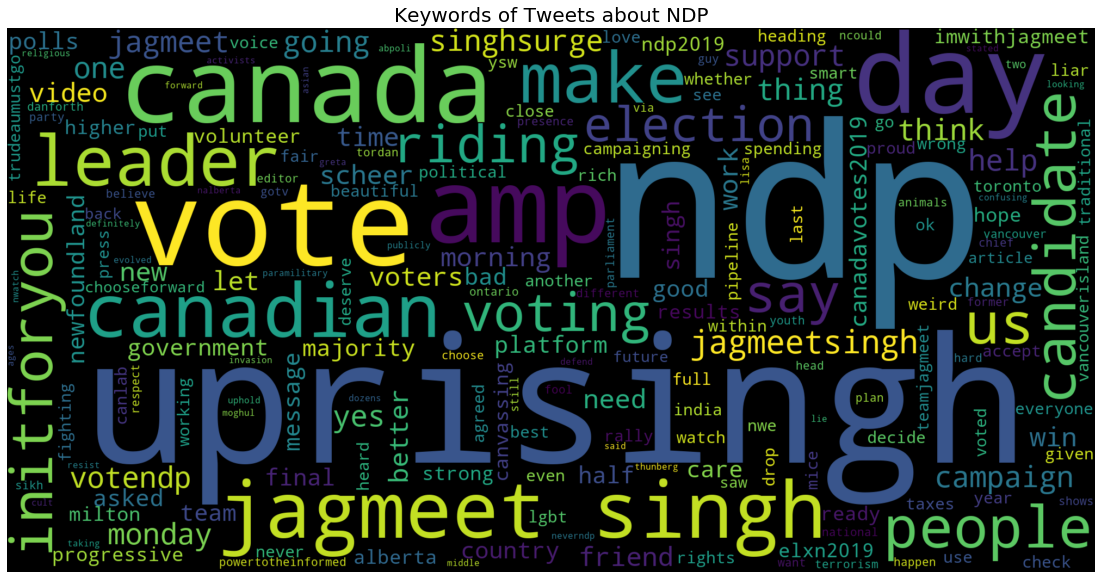

In [19]:
ndp= convert_tweets_to_words(ndp_tweet)
ndp_str = ' '.join(ndp)
wordcloud = WordCloud(width = 2000, height = 1000).generate(ndp_str)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Tweets about NDP', fontsize= 20)
plt.axis("off")
plt.show()

Word cloud helps in gaining insight about the key words for the different parties. We can clearly see the main reasons why the tweets were classified for each party.
They contain slogans for the parties, for example- "Choose Forward" for the Liberals.

How about uprisingh for the NDP? That is an interesting one.

These word clouds were also helpful in identifying some of the repeated words that were later added to the list of stop words. These words were just repeated for most of the tweets, example- canada, canadian, elxn43, etc.

# Bonus-

Lets try visualizing the results before going into any of the models.
Recall that we also saved the indexes for the tweets regarding the 3 major parties. These will now be used to capture their actual sentiment ratings and see which party is doing well.

In [20]:
#Using the indexes to get the sentiment for each party
liberal_sentiments, conservative_sentiments, ndp_sentiments= [],[],[]
for i in liberal_index:
    liberal_sentiments.append(df_elections["sentiment"][i])
for i in conservative_index:
    conservative_sentiments.append(df_elections["sentiment"][i])
for i in ndp_index:
    ndp_sentiments.append(df_elections["sentiment"][i])    

In [21]:
#This is created for plotting purposes. Seperating all the positive and negative sentiment counts for the three party
negative= []
negative.append(list(OrderedDict(sorted(Counter(liberal_sentiments).items())).values())[0])
negative.append(list(OrderedDict(sorted(Counter(conservative_sentiments).items())).values())[0])
negative.append(list(OrderedDict(sorted(Counter(ndp_sentiments).items())).values())[0])

positive=[]
positive.append(list(OrderedDict(sorted(Counter(liberal_sentiments).items())).values())[1])
positive.append(list(OrderedDict(sorted(Counter(conservative_sentiments).items())).values())[1])
positive.append(list(OrderedDict(sorted(Counter(ndp_sentiments).items())).values())[1])

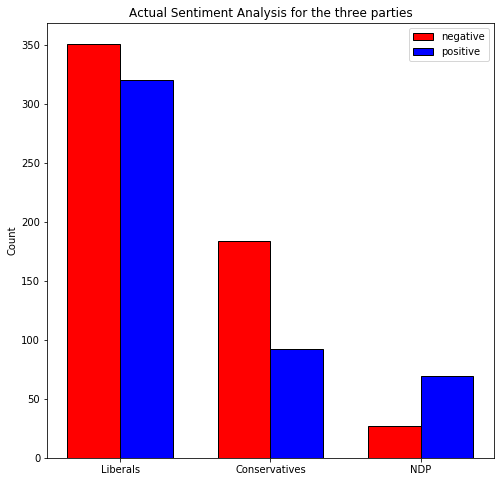

In [22]:
#Plotting the results for all parties in one plot
plt.figure(figsize=(8, 8))
ind= np.arange(3)
width = 0.35   

plt.bar(ind, negative, width, label='negative',color= 'red', edgecolor= 'black', linewidth= 1)
plt.bar(ind+width, positive, width, label='positive', color= 'blue', edgecolor= 'black', linewidth= 1)

plt.xticks(ind+width/2,("Liberals","Conservatives","NDP"))
plt.legend(loc='best')
plt.ylabel("Count")
plt.title("Actual Sentiment Analysis for the three parties")
plt.show()

Even though the Liberals had more negatives, they also had the most positive tweets. In fact, they have more than the amount of positive tweets as Conservatives and NDP combined. This gives us a very good indication since the Liberals ended up winning the elections.

It is important to notice that there were various tweets that were not classified (Others) which could belong to any of the three parties and might have an effect on the results.

Lets look at how the negative reasons are distributed.

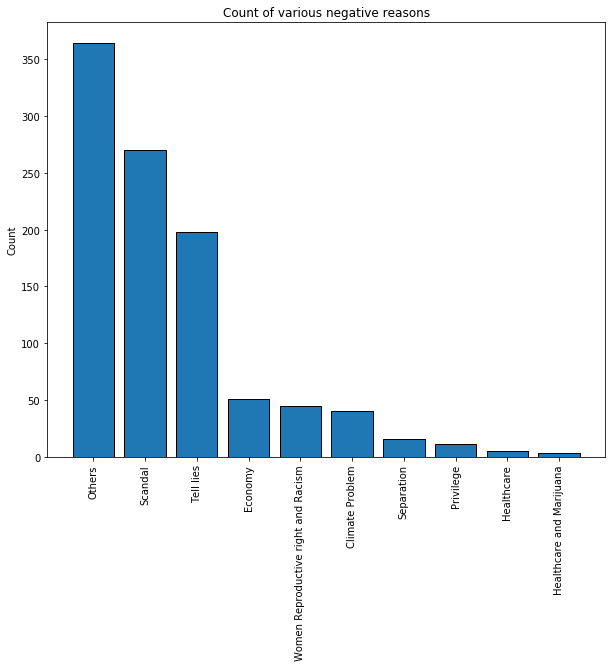

In [23]:
df_negative= df_elections[df_elections["sentiment"]=="negative"]

#Using the operator and collections library to sort the dict values in ascending order of count of tweets
negative_dict= OrderedDict(sorted(Counter(df_negative["negative_reason"]).items(), key=operator.itemgetter(1), reverse= True))

y= negative_dict.values()
x= negative_dict.keys()

plt.figure(figsize=(10, 8))
plt.bar(x,y,edgecolor="black",linewidth=1)
plt.ylabel("Count")
plt.title("Count of various negative reasons")
plt.xticks(rotation='vertical')
plt.show()

The negative reasons data is being dominated by the top 3 reasons which seem to make more than 80% of the data. This would make it tough for the machine learning models to classify the other groups since they do not have much data. There might be even less data when it is splitted into training and test sets.

Which party had more of the negative reasons category?

In [24]:
#Using the indexes to get the negative reasons for each party
liberal_reasons, conservative_reasons, ndp_reasons= [],[],[]
for i in liberal_index:
    if df_elections["sentiment"][i]== "negative":
        liberal_reasons.append(df_negative["negative_reason"][i])
for i in conservative_index:
    if df_elections["sentiment"][i]== "negative":
        conservative_reasons.append(df_negative["negative_reason"][i])
for i in ndp_index:
    if df_elections["sentiment"][i]== "negative":
        ndp_reasons.append(df_negative["negative_reason"][i])    

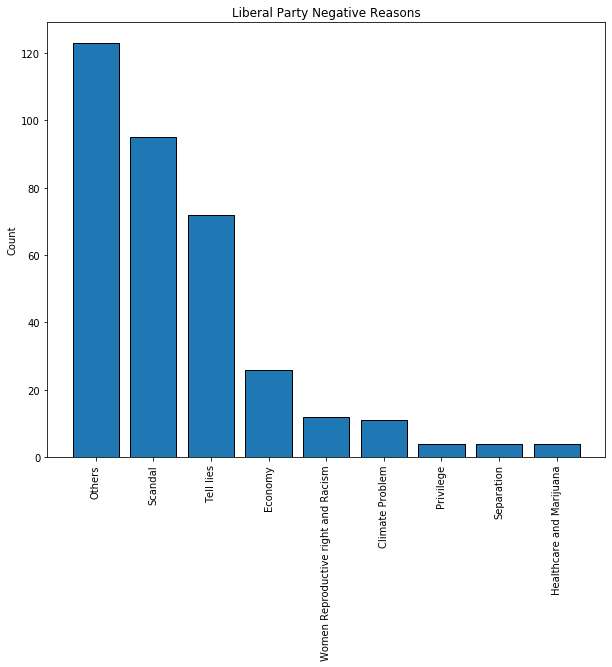

In [25]:
reasons_dict= OrderedDict(sorted(Counter(liberal_reasons).items(), key=operator.itemgetter(1), reverse= True))
x= Counter(reasons_dict).keys()
y= Counter(reasons_dict).values()


plt.figure(figsize=(10, 8))
plt.bar(x,y,edgecolor="black",linewidth=1)
plt.ylabel("Count")
plt.title("Liberal Party Negative Reasons")
plt.xticks(rotation='vertical')
plt.show()

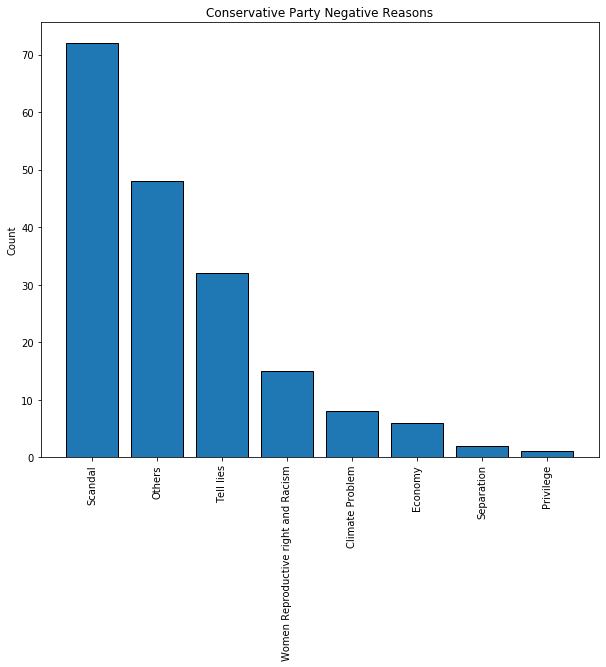

In [26]:
reasons_dict= OrderedDict(sorted(Counter(conservative_reasons).items(), key=operator.itemgetter(1), reverse= True))
x= Counter(reasons_dict).keys()
y= Counter(reasons_dict).values()


plt.figure(figsize=(10, 8))
plt.bar(x,y,edgecolor="black",linewidth=1)
plt.ylabel("Count")
plt.title("Conservative Party Negative Reasons")
plt.xticks(rotation='vertical')
plt.show()

Both the Liberals and Conservatives were hit hard by the Scandals and lies. This is expected as there were sevaral instances of party leaders being exposed for some secrets during the election campaign. Most notably, the blackface incident (for Liberals) and US passport issue (for Conservatives). These issues are highlighted in these plots and could be the reason why Liberals did not have the same support they did in the previous election campaign. These could be potentially areas for the different parties that they could to focus on during the election campaigns.

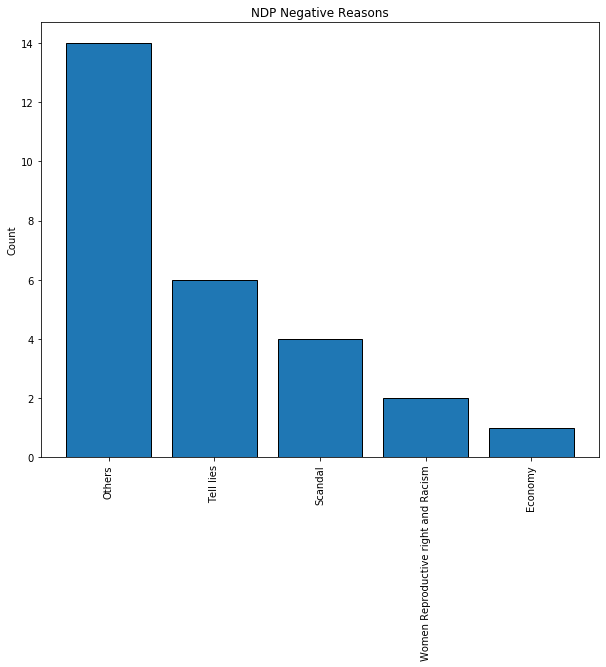

In [27]:
reasons_dict= OrderedDict(sorted(Counter(ndp_reasons).items(), key=operator.itemgetter(1), reverse= True))
x= Counter(reasons_dict).keys()
y= Counter(reasons_dict).values()


plt.figure(figsize=(10, 8))
plt.bar(x,y,edgecolor="black",linewidth=1)
plt.ylabel("Count")
plt.title("NDP Negative Reasons")
plt.xticks(rotation='vertical')
plt.show()

This plot is not as useful for the NDP since there were not many negative tweets to see the reasons for.

## 3- Model Preparation

There are two ways of text preparation techniques used in this case. The first one is using Count Vectorizer and TFIDF model.

In [28]:
X= df_generic['text'] #generic tweets
y= LabelEncoder().fit_transform(df_generic['class']) #to have targets as 0 and 1 as oppossed to 0 and 4

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

### 3.1- Count Vectorizer

Bag of Words (BOW) is a method to extract features from text documents. These features can be used for training machine learning algorithms. It creates a vocabulary of all the unique words occurring in all the documents in the training set.
In simple terms, it’s a collection of words to represent a sentence with word count and mostly disregarding the order in which they appear.

The first case is the simple Count Vectorizer which utilizes the amount of times the words are repeated in the various tweets.

Pros:
- Easy to implement and understand

Cons:

- Semantic meaning: the basic BOW approach does not consider the meaning of the word in the document. It completely ignores the context in which it’s used. The same word can be used in multiple places based on the context or nearby words.
- Vector size: For a large document, the vector size can be huge resulting in a lot of computation and time. 

In [30]:
vectorizer = CountVectorizer(analyzer = "word", # the feature should be made of word
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = 'english', # Remove stop words such as “the”, “a”, etc.
                             max_features = 5000) 

In [31]:
count_train = vectorizer.fit_transform(X_train)
count_test = vectorizer.transform(X_test)

### 3.2- TF-IDF

An alternative is to calculate word frequencies is called TF-IDF. This is an acronym than stands for “Term Frequency – Inverse Document” Frequency which are the components of the resulting scores assigned to each word.

Occurrence count (Count Vectorizer) is a good start but there is an issue: longer documents will have higher average count values than shorter documents, even though they might talk about the same topics. To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called tf for Term Frequencies.

Pros:
- Easy to compute
- Basic metric to extract the most descriptive terms in a document
- Easy to compute the similarity between 2 documents using it

Disadvantages:
- TF-IDF is based one the bag-of-words (BoW) model, therefore it does not capture position in text, semantics, co-occurrences in different documents, etc. This can be done via embeddings.

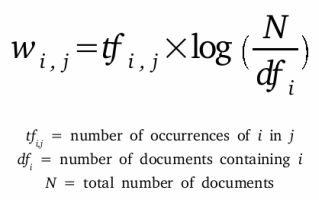

# Bonus-
ngram is used in addition to the tfidf vectorizer. An n-gram is just a string of n words in a row. E.g. the sentence ‘I am sick’ contains the 2-grams ‘I am’ and ‘am sick’. The sentence is itself a 3-gram. 
The default ngram_range is (1,1). I have considered the ngram_range as (1,2) which is unigrams and bigrams.

For problems like Sentiment Analysis, setting n-gram ranges that use bigrams or trigrams can dramatically improve the accuracy of classification, as they can capture more complex expressions formed by the composition of more than one word. The rationale is that in Sentiment Analysis the outcome depends not only on the frequency of words but also on how they are combined: good has a different meaning alone than when preceded by a not as in not good.

In [32]:
tfidf_vectorizer = TfidfVectorizer(stop_words = "english", max_df=0.7, max_features= 5500, ngram_range= (1,2))
#number of features were chosen based on the hyperparameter tuning in the next section

In [33]:
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

The results from the TFIDF are quite similar to the one obtained from Count Vectorizer which could suggest that the models may perform a similar manner for both the feature techniques. 

## 4- Model Implementation

There are seven models used for both Count Vectorizer and TFIDF.
1. Decision Tree
2. Random Forest
3. XG Boost
4. K-Nearest Neighbours (KNN)
5. Support Vector Machines (SVM)
6. Naive Bayes
7. Logistic Regression

There are four metrics measured for each model:
1. Train Set Accuracy: Accuracy of the model in predicting the train set. Useful to see in case the model is overfitting.
2. Test Set Accuracy: Accuracy of the model in predicting unseen data.
3. Precision: Similar metric to accuracy, but measures only the rate of false positives. Precision means the percentage of your results which are relevant.
4. Recall: refers to the percentage of total relevant results correctly classified by the algorithm.

Since accuracy alone might not be enough to choose the best model; precision and recall might help break the tie.

This sections has the following parts:
- Implementation of the 7 models using Count Vectorizer and TFIDF (14 models in total)
- The best of the 14 models is used on the canadian election tweets. The canadian election tweet seperated for the 3 parties in Section 2 is also used for sentiment prediction using the model for comparison to actual results.
- Negative tweets splitted into different groups and 4 models (using TFIDF) are implemented and discussed.

### 4.1- Generic Tweets Model using Count Vectorizer

#### 4.1.1- Decision Tree

A Decision Tree is a simple representation for classifying examples. It is a Supervised Machine Learning where the data is continuously split according to a certain parameter.

Pros:
- Simple to understand and interpret. People are able to understand decision tree models after a brief explanation.
- Compared to other algorithms, decision trees requires less effort for data preparation during pre-processing.
- Does not require normalization or scaling of data.
- Missing values in the data does not affect the process of building decision tree to any considerable extent.

Cons:

- A small change in the data can cause a large change in the structure of the decision tree causing instability.
- For a Decision tree sometimes calculation can go far more complex compared to other algorithms.
- Decision tree often involves higher time to train the model.
- Decision Tree algorithm is inadequate for applying regression and predicting continuous values.

Instead of using the regular Decision Tree, I decided to test the different hyperparameters and cross validation (5 folds). I have just left it as random integers now to save computational time.

In [34]:
#Parameters to be tested
from scipy.stats import randint
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

In [35]:
tree_cv = RandomizedSearchCV(DecisionTreeClassifier(), param_dist, cv=5)
tree_cv.fit(count_train,y_train)
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 2}


In [36]:
train_predictions= tree_cv.predict(count_train)
test_predictions = tree_cv.predict(count_test)

accuracy_train = metrics.accuracy_score(y_train, train_predictions)
accuracy_test= metrics.accuracy_score(y_test, test_predictions)
precision_test= metrics.precision_score(y_test, test_predictions)
recall_test= metrics.recall_score(y_test, test_predictions)

print("Train Set Accuracy:", accuracy_train)
print("Test Set Accuracy:", accuracy_test)
print("Precision of the test set:", precision_test)
print("Recall of the test set:", recall_test)

Train Set Accuracy: 0.6876
Test Set Accuracy: 0.6732
Precision of the test set: 0.6572016583649
Recall of the test set: 0.7308368436764072


#### 4.1.2- Random Forest

A random forest is an ensemble learning method for classification, regression and other tasks that that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

Pros:

- The predictive performance can compete with the best supervised learning algorithms
- They offer efficient estimates of the test error without incurring the cost of repeated model training associated with cross-validation
- important when dealing with mulitple features which may be correlated
- reduced variance (relative to regular decision trees)

Cons:
- Not as easy to visually interpret
- Training a large number of deep trees can have high computational costs

In [37]:
forest_cv = RandomForestClassifier()
forest_cv.fit(count_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [38]:
train_predictions= forest_cv.predict(count_train)
test_predictions= forest_cv.predict(count_test)

accuracy_train = metrics.accuracy_score(y_train, train_predictions)
accuracy_test= metrics.accuracy_score(y_test, test_predictions)
precision_test= metrics.precision_score(y_test, test_predictions)
recall_test= metrics.recall_score(y_test, test_predictions)

print("Train Set Accuracy:", accuracy_train)
print("Test Set Accuracy:", accuracy_test)
print("Precision of the test set:", precision_test)
print("Recall of the test set:", recall_test)

Train Set Accuracy: 0.9627
Test Set Accuracy: 0.7171166666666666
Precision of the test set: 0.725169184496548
Recall of the test set: 0.7037381007661946


#### 4.1.3- XG Boost

Boosting is a sequential technique which works on the principle of an ensemble. It combines a set of weak learners and delivers improved prediction accuracy.
XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework.

Pros:
- Since boosted trees are derived by optimizing an objective function, basically XGB can be used to solve almost all objective function that we can write gradient out.
- XGBoost has an in-built capability to handle missing values.
- XGBoost allows user to run a cross-validation at each iteration of the boosting process and thus it is easy to get the exact optimum number of boosting iterations in a single run.

Cons:
- XGB model is more sensitive to overfitting if the data is noisy. 
- Training generally takes longer because of the fact that trees are built sequentially. 
- Not easy to interpret.

In [39]:
xgb_boosting= XGBClassifier()
xgb_boosting.fit(count_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [40]:
train_predictions= xgb_boosting.predict(count_train)
test_predictions= xgb_boosting.predict(count_test)

accuracy_train = metrics.accuracy_score(y_train, train_predictions)
accuracy_test= metrics.accuracy_score(y_test, test_predictions)
precision_test= metrics.precision_score(y_test, test_predictions)
recall_test= metrics.recall_score(y_test, test_predictions)

print("Train Set Accuracy:", accuracy_train)
print("Test Set Accuracy:", accuracy_test)
print("Precision of the test set:", precision_test)
print("Recall of the test set:", recall_test)

Train Set Accuracy: 0.6640428571428572
Test Set Accuracy: 0.6617833333333333
Precision of the test set: 0.6130327079223817
Recall of the test set: 0.8864970645792564


#### 4.1.4- KNN Classification

The k-nearest neighbors (KNN) algorithm is a simple, supervised machine learning algorithm that can be used to solve both classification and regression problems. We are using the classifier in this case.
 
Pros:
- Easy to implement and understand
- No assumptions about the data
- Instance-based learning means that our algorithm doesn’t explicitly learn a model. Instead, it chooses to memorize the training instances which are subsequently used as “knowledge” for the prediction phase.

Cons:
- Computationally expensive when the data size grows
- It can suffer from skewed class distributions. For example, if a certain class is very frequent in the training set, it will tend to dominate the majority voting of the new example (large number = more common). 
- accuracy of KNN can be severely degraded with high-dimension data because there is little difference between the nearest and farthest neighbor.
- Sensitive to the right value of K (nearest neighbors)

In [41]:
#create an initial test kNN classifier and pass it the training data
knnclassifier = KNeighborsClassifier(n_neighbors=5)
knnclassifier.fit(count_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [42]:
train_predictions= knnclassifier.predict(count_train)
test_predictions= knnclassifier.predict(count_test)

accuracy_train = metrics.accuracy_score(y_train, train_predictions)
accuracy_test= metrics.accuracy_score(y_test, test_predictions)
precision_test= metrics.precision_score(y_test, test_predictions)
recall_test= metrics.recall_score(y_test, test_predictions)

print("Train Set Accuracy:", accuracy_train)
print("Test Set Accuracy:", accuracy_test)
print("Precision of the test set:", precision_test)
print("Recall of the test set:", recall_test)

Train Set Accuracy: 0.7725928571428572
Test Set Accuracy: 0.6729666666666667
Precision of the test set: 0.6554994239120802
Recall of the test set: 0.7359448074563004


#### 4.1.5- Support Vector Machines (SVM)

A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples.
We are using the SVC in this case which is used for classification.

Pros:
- Performs similarly to logistic regression when linear separation
- Performs well with non-linear boundary depending on the kernel used
- Handle high dimensional data well

Cons:
- Susceptible to overfitting/training issues depending on kernel
- For larger dataset, it requires a large amount of time to process.
- Does not perform well in case of overlapped classes.

In [43]:
SVM = LinearSVC()
SVM.fit(count_train,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [44]:
train_predictions= SVM.predict(count_train)
test_predictions= SVM.predict(count_test)

accuracy_train = metrics.accuracy_score(y_train, train_predictions)
accuracy_test= metrics.accuracy_score(y_test, test_predictions)
precision_test= metrics.precision_score(y_test, test_predictions)
recall_test= metrics.recall_score(y_test, test_predictions)

print("Train Set Accuracy:", accuracy_train)
print("Test Set Accuracy:", accuracy_test)
print("Precision of the test set:", precision_test)
print("Recall of the test set:", recall_test)

Train Set Accuracy: 0.7769142857142857
Test Set Accuracy: 0.75375
Precision of the test set: 0.7387860337972167
Recall of the test set: 0.7888487180337657


#### 4.1.6 Naive Bayes

Naive Bayes is a statistical classification technique based on Bayes Theorem. It is one of the simplest supervised learning algorithms. Naive Bayes classifier is the fast, accurate and reliable algorithm. Naive Bayes classifiers have high accuracy and speed on large datasets.

Pros:
- Easy to use and interpret.
- Naive Bayes algorithm only requires one pass on the entire dataset to calculate the posterior probabilities for each value of the feature in the dataset. 

- Since all the probabilities are pre-computed in the Naive Bayes algorithm, the prediction time of this algorithm is very efficient.

- Since the predictions of Naive Bayes algorithms are based on the posterior probability of each conditional feature, it is easy to understand which features are influencing the predictions. This helps users to understand the predictions.

Cons:
- It has a ‘Zero conditional probability Problem’, for features having zero frequency the total probability also becomes zero. There are several sample correction techniques to fix this problem such as “Laplacian Correction.”

- Another disadvantage is the very strong assumption of independence class features that it makes. It is near to impossible to find such data sets in real life.

The one most suitable for word counts is the multinomial variant: Multinomial NB

In [45]:
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [46]:
train_predictions= nb_classifier.predict(count_train)
test_predictions= nb_classifier.predict(count_test)

accuracy_train = metrics.accuracy_score(y_train, train_predictions)
accuracy_test= metrics.accuracy_score(y_test, test_predictions)
precision_test= metrics.precision_score(y_test, test_predictions)
recall_test= metrics.recall_score(y_test, test_predictions)

print("Train Set Accuracy:", accuracy_train)
print("Test Set Accuracy:", accuracy_test)
print("Precision of the test set:", precision_test)
print("Recall of the test set:", recall_test)

Train Set Accuracy: 0.7617071428571428
Test Set Accuracy: 0.7475333333333334
Precision of the test set: 0.7551277254328379
Recall of the test set: 0.7363428306079803


#### 4.1.7- Logistic Regression

 Logistic Regression is a supervised machine learning algorithm used in binary classification (usually).
 
Pros: 
- easy to interpret. the output can be interpreted as a probability: you can use it for ranking instead of classification.
- good for cases where features are expected to be roughly linear, and the problem to be linearly separable.
- can easily "feature engineering" most non-linear features into linear ones.
- robust to noise
- can use l2 or l1 regularization to avoid overfitting(and for feature selection)

Cons:
- Can't solve non-linear problems
- It is not a useful tool unless you have already identified all the important independent variables. Since its outcome is discrete, Logistic Regression can only predict a categorical outcome.
- It is also an Algorithm that is known for its vulnerability to overfitting.

In [47]:
model= LogisticRegression()
model.fit(count_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
train_predictions= model.predict(count_train)
test_predictions= model.predict(count_test)

accuracy_train = metrics.accuracy_score(y_train, train_predictions)
accuracy_test= metrics.accuracy_score(y_test, test_predictions)
precision_test= metrics.precision_score(y_test, test_predictions)
recall_test= metrics.recall_score(y_test, test_predictions)

print("Train Set Accuracy:", accuracy_train)
print("Test Set Accuracy:", accuracy_test)
print("Precision of the test set:", precision_test)
print("Recall of the test set:", recall_test)

Train Set Accuracy: 0.7775
Test Set Accuracy: 0.75525
Precision of the test set: 0.7427477081501946
Recall of the test set: 0.7847026435370991


All the 7 models gave good results. It is important to note that some models might do even better with hyperparameter tuning of the algorithm or changing the number of TFIDF features. The highest test accuracy here was given by SVM and Logistic Regression. However, Logistic Regression had a test accuracy and precision score slightly higher than SVM whereas SVM had a better recall rate.
Albeit slight margins, Logistic Regression is the best for this round.

Lets move on to TFIDF.

### 4.2- Generic Tweets model with TF-IDF 

Same three models used for TFIDF for comparison

#### 4.2.1- Decision Tree

In [49]:
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

In [50]:
tree_cv = RandomizedSearchCV(DecisionTreeClassifier(), param_dist, cv=5)
tree_cv.fit(tfidf_train,y_train)
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'min_samples_leaf': 2}


In [51]:
train_predictions= tree_cv.predict(tfidf_train)
test_predictions = tree_cv.predict(tfidf_test)

accuracy_train = metrics.accuracy_score(y_train, train_predictions)
accuracy_test= metrics.accuracy_score(y_test, test_predictions)
precision_test= metrics.precision_score(y_test, test_predictions)
recall_test= metrics.recall_score(y_test, test_predictions)

print("Train Set Accuracy:", accuracy_train)
print("Test Set Accuracy:", accuracy_test)
print("Precision of the test set:", precision_test)
print("Recall of the test set:", recall_test)

Train Set Accuracy: 0.7103928571428572
Test Set Accuracy: 0.6776666666666666
Precision of the test set: 0.6613524406627855
Recall of the test set: 0.7347507380012605


#### 4.2.2- Random Forest

In [52]:
forest_cv = RandomForestClassifier()
forest_cv.fit(tfidf_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [53]:
train_predictions= forest_cv.predict(tfidf_train)
test_predictions= forest_cv.predict(tfidf_test)

accuracy_train = metrics.accuracy_score(y_train, train_predictions)
accuracy_test= metrics.accuracy_score(y_test, test_predictions)
precision_test= metrics.precision_score(y_test, test_predictions)
recall_test= metrics.recall_score(y_test, test_predictions)

print("Train Set Accuracy:", accuracy_train)
print("Test Set Accuracy:", accuracy_test)
print("Precision of the test set:", precision_test)
print("Recall of the test set:", recall_test)

Train Set Accuracy: 0.9593571428571429
Test Set Accuracy: 0.7253833333333334
Precision of the test set: 0.7343021661639704
Recall of the test set: 0.7106040001326743


#### 4.2.3- XG Boost

In [54]:
xgb_boosting= XGBClassifier()
xgb_boosting.fit(tfidf_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [55]:
train_predictions= xgb_boosting.predict(tfidf_train)
test_predictions= xgb_boosting.predict(tfidf_test)

accuracy_train = metrics.accuracy_score(y_train, train_predictions)
accuracy_test= metrics.accuracy_score(y_test, test_predictions)
precision_test= metrics.precision_score(y_test, test_predictions)
recall_test= metrics.recall_score(y_test, test_predictions)

print("Train Set Accuracy:", accuracy_train)
print("Test Set Accuracy:", accuracy_test)
print("Precision of the test set:", precision_test)
print("Recall of the test set:", recall_test)

Train Set Accuracy: 0.6664
Test Set Accuracy: 0.66235
Precision of the test set: 0.6134746890632888
Recall of the test set: 0.8867292447510697


#### 4.2.4- KNN Classification

In [56]:
#create an initial test kNN classifier and pass it the training data
knnclassifier = KNeighborsClassifier(n_neighbors=5)
knnclassifier.fit(tfidf_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [57]:
train_predictions= knnclassifier.predict(tfidf_train)
test_predictions= knnclassifier.predict(tfidf_test)

accuracy_train = metrics.accuracy_score(y_train, train_predictions)
accuracy_test= metrics.accuracy_score(y_test, test_predictions)
precision_test= metrics.precision_score(y_test, test_predictions)
recall_test= metrics.recall_score(y_test, test_predictions)

print("Train Set Accuracy:", accuracy_train)
print("Test Set Accuracy:", accuracy_test)
print("Precision of the test set:", precision_test)
print("Recall of the test set:", recall_test)

Train Set Accuracy: 0.7526
Test Set Accuracy: 0.63665
Precision of the test set: 0.6259885300332025
Recall of the test set: 0.6878835118909417


#### 4.2.5- Support Vector Machines (SVM)

In [58]:
SVM = LinearSVC()
SVM.fit(tfidf_train,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [59]:
train_predictions= SVM.predict(tfidf_train)
test_predictions= SVM.predict(tfidf_test)

accuracy_train = metrics.accuracy_score(y_train, train_predictions)
accuracy_test= metrics.accuracy_score(y_test, test_predictions)
precision_test= metrics.precision_score(y_test, test_predictions)
recall_test= metrics.recall_score(y_test, test_predictions)

print("Train Set Accuracy:", accuracy_train)
print("Test Set Accuracy:", accuracy_test)
print("Precision of the test set:", precision_test)
print("Recall of the test set:", recall_test)

Train Set Accuracy: 0.7793785714285715
Test Set Accuracy: 0.7544666666666666
Precision of the test set: 0.7435160322223977
Recall of the test set: 0.7806560748283525


#### 4.2.6- Naive Bayes

In [60]:
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [61]:
train_predictions= nb_classifier.predict(tfidf_train)
test_predictions= nb_classifier.predict(tfidf_test)

accuracy_train = metrics.accuracy_score(y_train, train_predictions)
accuracy_test= metrics.accuracy_score(y_test, test_predictions)
precision_test= metrics.precision_score(y_test, test_predictions)
recall_test= metrics.recall_score(y_test, test_predictions)

print("Train Set Accuracy:", accuracy_train)
print("Test Set Accuracy:", accuracy_test)
print("Precision of the test set:", precision_test)
print("Recall of the test set:", recall_test)

Train Set Accuracy: 0.7611428571428571
Test Set Accuracy: 0.7449166666666667
Precision of the test set: 0.7489100543295996
Recall of the test set: 0.740687916680487


#### 4.2.7- Logistic Regression

In [62]:
model= LogisticRegression()
model.fit(tfidf_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [63]:
train_predictions= model.predict(tfidf_train)
test_predictions= model.predict(tfidf_test)

accuracy_train = metrics.accuracy_score(y_train, train_predictions)
accuracy_test= metrics.accuracy_score(y_test, test_predictions)
precision_test= metrics.precision_score(y_test, test_predictions)
recall_test= metrics.recall_score(y_test, test_predictions)

print("Train Set Accuracy:", accuracy_train)
print("Test Set Accuracy:", accuracy_test)
print("Precision of the test set:", precision_test)
print("Recall of the test set:", recall_test)

Train Set Accuracy: 0.7781428571428571
Test Set Accuracy: 0.7572666666666666
Precision of the test set: 0.7476876132354343
Recall of the test set: 0.7802248830806991


Logistic Regression wins again in the same manner as earlier, beating SVM by having a slightly better accuarcy and precision whereas SVM had a better recall rate. The accuracy for Logistic Regression using both Count Vectorizer and TFIDF are similar with the results of TFIDF being slightly better.

In general, the models performed well for both the TFIDF and Count Vectorizer. Decision Trees perform better when the number of features are lower. The ensebmles (specially Random Forest) produced a good accuracy. XG Boost produced the best recall rate of all models which could be essential in case the recall is a priority to the other metrics.
KNN and SVM require a high computational time but produced good results. Naive Bayes is a simple model which does a good job in predicting the results.

Also, the results from TFIDF and Count Vectorizer are quite comparable for most models. KNN produced results that were a bit different which is due to the fact that KNN is looking at the nearest neighbors and they would be different for both types of features

In summary, Logistic Regression with TFIDF will be chosen as the best model because of slightly better results.

### 4.3- Implementation of the best model on Canadian Elections tweets

Logistic Regression with TF-IDF produced the best results with a test accuracy of 76% and hence this model will be used on the canadian election tweets.

In [64]:
X_elections= df_elections["text"] #Canadian election tweets
y_elections= LabelEncoder().fit_transform(df_elections['sentiment']) #to have targets as 0 and 1 as oppossed to positive or negative

The same TFIDF vectorizer, used earlier, is being used to transform the test data (which is Canadian election tweets).

In [65]:
X_elections_tfidf = tfidf_vectorizer.transform(X_elections)

In [66]:
#Using the logistic regression model with tfidf features
model= LogisticRegression()
model.fit(tfidf_train,y_train) 

election_sentiment_predictions= model.predict(X_elections_tfidf) 
accuracy = metrics.accuracy_score(y_elections, election_sentiment_predictions)
print("Elections Sentiment Prediction Accuracy:", accuracy)

Elections Sentiment Prediction Accuracy: 0.5996249413970933


The accuracy on the elections is 60%.
Visualizing the sentiment analysis for the Canadian Elections.

First, the overall distribution from the predicted and actual model:

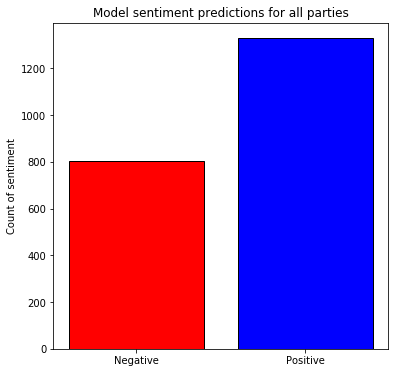

In [67]:
#Model predicted sentiment 
y= OrderedDict(sorted(Counter(election_sentiment_predictions).items())).values()
x= ['Negative','Positive']

plt.figure(figsize=(6, 6))
plt.bar(x,y,edgecolor="black",linewidth=1, color=["red","blue"])
plt.ylabel("Count of sentiment")
plt.title("Model sentiment predictions for all parties")
plt.show()

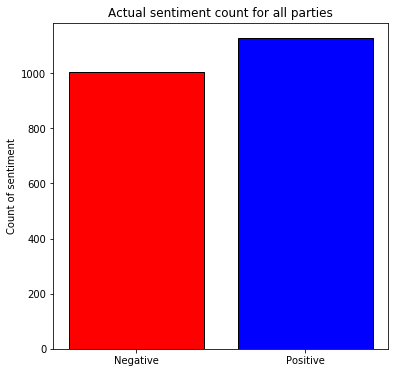

In [68]:
#Actual sentiment
y= OrderedDict(sorted(Counter(df_elections["sentiment"]).items())).values()
x= ['Negative','Positive']

plt.figure(figsize=(6, 6))
plt.bar(x,y,edgecolor="black",linewidth=1, color=["red","blue"])
plt.ylabel("Count of sentiment")
plt.title("Actual sentiment count for all parties")
plt.show()

As the accuracy of 60% suggested, the results differ but mainly for the positive tweets. It looks like our model has failed to classify the negative tweets and considered them as positive instead. This will be explored further in Section 5.

Now we use the seperated tweets for the three major parties and use our model to predict the sentiments for each party.

In [69]:
#Using the model to predict sentiments just for the liberal party
liberal_tfidf= tfidf_vectorizer.transform(liberal_tweet)
liberal_predictions= model.predict(liberal_tfidf)

In [70]:
#Using the model to predict sentiments just for the conservative party
conservative_tfidf= tfidf_vectorizer.transform(conservative_tweet)
conservative_predictions= model.predict(conservative_tfidf)

In [71]:
#Using the model to predict sentiments just for the NDP
ndp_tfidf= tfidf_vectorizer.transform(ndp_tweet)
ndp_predictions= model.predict(ndp_tfidf)

In [72]:
#This is created for plotting purposes. Seperating all the positive and negative sentiment counts for the three party
negative= []
negative.append(list(OrderedDict(sorted(Counter(liberal_predictions).items())).values())[0])
negative.append(list(OrderedDict(sorted(Counter(conservative_predictions).items())).values())[0])
negative.append(list(OrderedDict(sorted(Counter(ndp_predictions).items())).values())[0])

positive=[]
positive.append(list(OrderedDict(sorted(Counter(liberal_predictions).items())).values())[1])
positive.append(list(OrderedDict(sorted(Counter(conservative_predictions).items())).values())[1])
positive.append(list(OrderedDict(sorted(Counter(ndp_predictions).items())).values())[1])

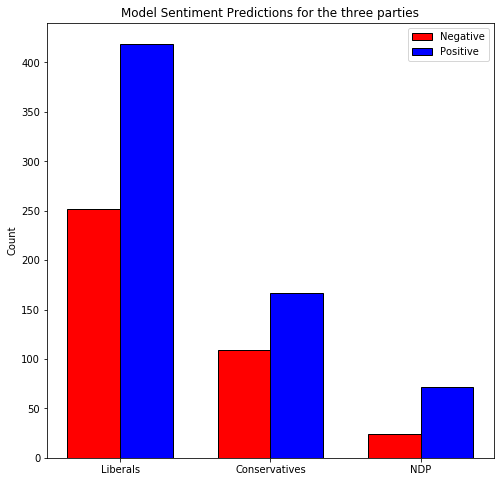

In [73]:
#Plotting the results for all parties in one plot
plt.figure(figsize=(8, 8))
ind= np.arange(3)
width = 0.35   

plt.bar(ind, negative, width, label='Negative',color= 'red', edgecolor= 'black', linewidth= 1)
plt.bar(ind+width, positive, width, label='Positive', color= 'blue', edgecolor= 'black', linewidth= 1)
plt.xticks(ind+width/2,("Liberals","Conservatives","NDP"))
plt.legend(loc='best')
plt.ylabel("Count")
plt.title("Model Sentiment Predictions for the three parties")
plt.show()

The negative tweets have not been classified correctly for the three parties as mentioned earlier. These figures along with the one in Section 2 (Bonus) are discussed in depth in Section 5 to avoid repetition of information.

# Bonus-

I have noticed the number of maximum features set in the TFIDF vectorizer has an effect in the accuracy. This hyperparameter tuning gives the accuracy for the generic tweets (train and test) and the elections data with respect to the change in the number of features. 

In addition, I have studied the effect of ngrams range on my results.

In [74]:
df_train_accuracy= pd.DataFrame()
df_test_accuracy= pd.DataFrame()
df_elections_accuracy= pd.DataFrame()

X_elections= df_elections["text"] #Canadian election tweets
y_elections= LabelEncoder().fit_transform(df_elections['sentiment']) #to have targets as 0 and 1 as oppossed to positive or negative

ngrams= [(1,1),(1,2),(2,2)]
i=0

for i in range (0,3): #loop for the different ngram options
    accuracy_train= []
    accuracy_test= []
    accuracy_elections= []
    for features in range(500,8000,500): #loop for the different count of features
    
        tfidf_vectorizer = TfidfVectorizer(stop_words = "english", max_df=0.7, max_features= features, ngram_range= ngrams[i])
        tfidf_train = tfidf_vectorizer.fit_transform(X_train)
        tfidf_test = tfidf_vectorizer.transform(X_test)
        X_elections_tfidf = tfidf_vectorizer.transform(X_elections)

        model= LogisticRegression()
        model.fit(tfidf_train,y_train)

        train_predictions= model.predict(tfidf_train)
        test_predictions= model.predict(tfidf_test)
        sentiment_predictions= model.predict(X_elections_tfidf)
        
        accuracy_train.append(metrics.accuracy_score(y_train, train_predictions))
        accuracy_test.append(metrics.accuracy_score(y_test, test_predictions))
        accuracy_elections.append(metrics.accuracy_score(y_elections, sentiment_predictions))
    
    #saving the results in a dataframe for each ngram range choice
    df_train_accuracy["Ngram option: %d" %i]= accuracy_train
    df_test_accuracy["Ngram option: %d" %i]= accuracy_test
    df_elections_accuracy["Ngram option: %d" %i]= accuracy_elections

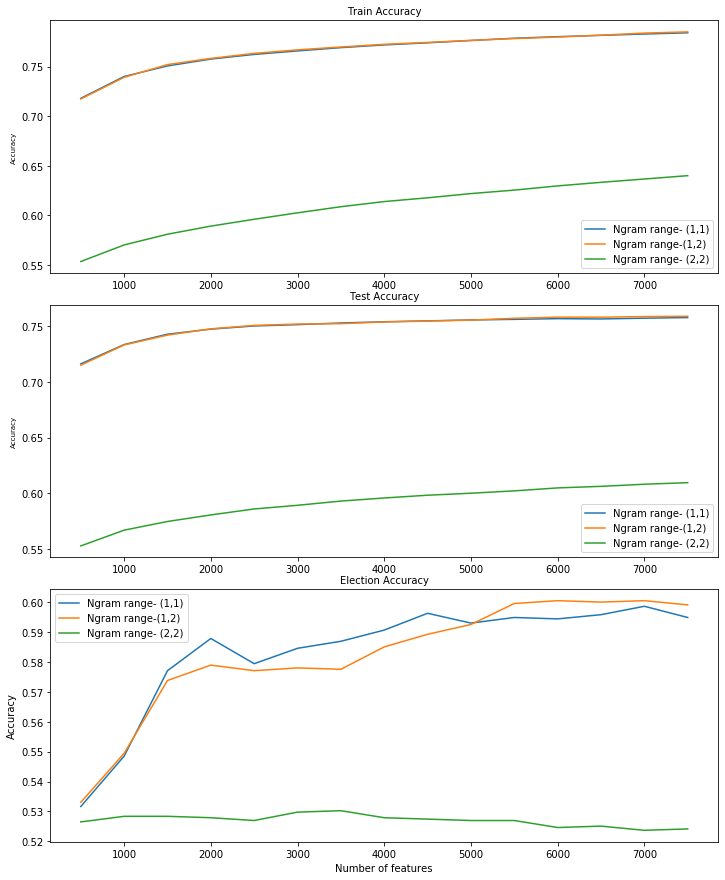

In [75]:
fig, axes = plt.subplots(3, figsize=(10,12))
fig.tight_layout() #for better layout

axes[0].plot(range(500,8000, 500),df_train_accuracy)
axes[0].set_title("Train Accuracy", fontsize= 10)
axes[0].set_ylabel("Accuracy", fontsize=7)
axes[0].legend(["Ngram range- (1,1)","Ngram range-(1,2)","Ngram range- (2,2)"])

axes[1].plot(range(500,8000, 500), df_test_accuracy)
axes[1].set_title("Test Accuracy", fontsize= 10)
axes[1].set_ylabel("Accuracy", fontsize=7)
axes[1].legend(["Ngram range- (1,1)","Ngram range-(1,2)","Ngram range- (2,2)"])

axes[2].plot(range(500,8000, 500), df_elections_accuracy)
axes[2].set_title("Election Accuracy", fontsize= 10)
axes[2].set_ylabel("Accuracy", fontsize=10)
axes[2].set_xlabel("Number of features", fontsize=10)
axes[2].legend(["Ngram range- (1,1)","Ngram range-(1,2)","Ngram range- (2,2)"])

plt.show()

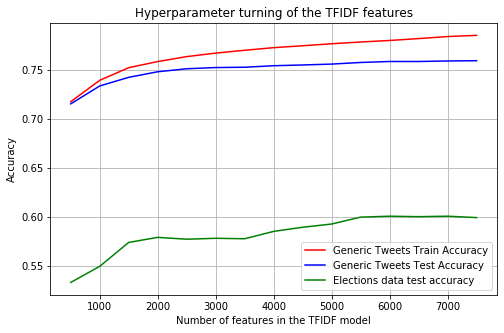

In [76]:
plt.figure(figsize=(8,5))
plt.plot(range(500,8000, 500), df_train_accuracy.iloc[:,1], 'r')
plt.plot(range(500,8000, 500), df_test_accuracy.iloc[:,1], 'b')
plt.plot(range(500,8000, 500), df_elections_accuracy.iloc[:,1], 'g')

plt.grid()
plt.xlabel("Number of features in the TFIDF model")
plt.title("Hyperparameter turning of the TFIDF features")
plt.ylabel("Accuracy")
plt.legend(["Generic Tweets Train Accuracy", "Generic Tweets Test Accuracy", "Elections data test accuracy"])
plt.show()

The graphs indicate that the best ngram_range to use is either (1,1) or (1,2). The accuracy reduces when the ngram range of (2,2) was used. Hence, the ngram range used in our previous model is (1,2) since for 5,500 features, the election sentiment accuracy is better than the other two, by slight margins.

The number of features has an effect on the accuracy of the different datasets. Feature of 5,500 was chosen based on these findings. As the number of features increases, the model would start overfitting as it can be seen from the graph- the train accruacy is increasing as the number of features increases.

### 4.4- Splitting negative election tweets

This section only considers the negative tweets from the elections. 
Note: The problem statement mentions: "You are free to define input features of your model using word frequency analysis or other techniques." and hence only TF-IDF is used for this case on the four models.

In [77]:
df_negative= df_elections[df_elections["sentiment"]=="negative"]
df_negative.head()

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,instead suggestion agree canadian women trust andrewscheer conservatives government protect woman right automony body let go canada abortion
2,negative,Economy,brantford going cost 94 billion next 4 years ask justin canada
4,negative,Economy,canada taxpayers sick amp tired hard earned donated corporate welfare bums need one many reasons trudeaumustgo leave canada care snclavalinscandal election2019
5,negative,Others,canadavotes2019 facts blastfromthepast 2012 conservatives introduced end long gun registry even though heads police across canada victims groups objected crime control public safety gunlobby
8,negative,Others,chooseforward ncanada make america mistakes full frontal tbs via


In [78]:
df_negative["negative_reason"].value_counts(normalize= True)

Others                                 0.361829
Scandal                                0.268390
Tell lies                              0.196819
Economy                                0.050696
Women Reproductive right and Racism    0.044732
Climate Problem                        0.040755
Separation                             0.015905
Privilege                              0.011928
Healthcare                             0.004970
Healthcare and Marijuana               0.003976
Name: negative_reason, dtype: float64

As indicated in Section 2 as well, there is imbalanced data with most of the data being available for the top 3 category: Other, Scandal and Tell Lies cover about 80% of the total reasons.

In [79]:
X= df_negative["text"]
y= df_negative["negative_reason"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [80]:
tfidf_vectorizer = TfidfVectorizer(stop_words = "english", max_df=0.7, max_features= 200, ngram_range= (1,2))
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

There are four models chosen for this scenario:
1. SVM
2. Random Forest
3. Naive Bayes
4. Logistic Regression


These were chosen because they gave the best results in the earlier section.

#### 4.4.1- Support Vector Machines

In [81]:
SVM = LinearSVC()
SVM.fit(tfidf_train,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [82]:
train_predictions= SVM.predict(tfidf_train)
test_predictions= SVM.predict(tfidf_test)

accuracy_train = metrics.accuracy_score(y_train, train_predictions)
accuracy_test= metrics.accuracy_score(y_test, test_predictions)

print("Train Set Accuracy:", accuracy_train)
print("Test Set Accuracy:", accuracy_test)

Train Set Accuracy: 0.7727272727272727
Test Set Accuracy: 0.5331125827814569


#### 4.4.2- Random Forest Classifier

In [83]:
forest_cv = RandomForestClassifier()
forest_cv.fit(tfidf_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [84]:
train_predictions= forest_cv.predict(tfidf_train)
test_predictions = forest_cv.predict(tfidf_test)

accuracy_train = metrics.accuracy_score(y_train, train_predictions)
accuracy_test= metrics.accuracy_score(y_test, test_predictions)

print("Train Set Accuracy:", accuracy_train)
print("Test Set Accuracy:", accuracy_test)

Train Set Accuracy: 0.9715909090909091
Test Set Accuracy: 0.5198675496688742


#### 4.4.3 Naive Bayes

In [85]:
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [86]:
train_predictions= nb_classifier.predict(tfidf_train)
test_predictions= nb_classifier.predict(tfidf_test)

accuracy_train = metrics.accuracy_score(y_train, train_predictions)
accuracy_test= metrics.accuracy_score(y_test, test_predictions)

print("Train Set Accuracy:", accuracy_train)
print("Test Set Accuracy:", accuracy_test)

Train Set Accuracy: 0.6051136363636364
Test Set Accuracy: 0.49337748344370863


#### 4.4.3 Logistic Regression

Note that we now have multinomial classification and not binary.

In [87]:
model= LogisticRegression(multi_class= 'multinomial', solver= "newton-cg")
model.fit(tfidf_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [88]:
train_predictions= model.predict(tfidf_train)
test_predictions= model.predict(tfidf_test)

accuracy_train = metrics.accuracy_score(y_train, train_predictions)
accuracy_test= metrics.accuracy_score(y_test, test_predictions)

print("Train Set Accuracy:", accuracy_train)
print("Test Set Accuracy:", accuracy_test)

Train Set Accuracy: 0.671875
Test Set Accuracy: 0.5231788079470199


Two key findings:
- Overfitting of the model when the number of TFIDF features is set too high for all models (this will be explored further).
- Low test set accuracy for all models.

To combat these two issues I did the following:
- reduce the max features to 200 to reduce overfitting
- change the number of reasons from 10 to 6 to increase accuracy of the model.

The number of reasons were reduced to 6 to have more data for a particular category. Scandal and Tell lies seem to be the same thing since they might both have similar words. However, grouping them would mean that almost 85% of the data comes from two categories and hence this was not done.
Instead, the groups with lower percentage were grouped together.

After the grouping of reasons, only Logistic Regression was implemented as it gave the best results.

In [89]:
df_negative[df_negative.loc[:,"negative_reason"]== "Healthcare"]= "Healthcare, Marijuana, Seperation and Privilege"
df_negative[df_negative.loc[:,"negative_reason"]== "Privilege"]=  "Healthcare, Marijuana, Seperation and Privilege"
df_negative[df_negative.loc[:,"negative_reason"]== "Separation"]= "Healthcare, Marijuana, Seperation and Privilege"
df_negative[df_negative.loc[:,"negative_reason"]== "Healthcare and Marijuana"]="Healthcare, Marijuana, Seperation and Privilege"

df_negative[df_negative.loc[:,"negative_reason"]== "Economy"]= "Climate Problem and Economy"
df_negative[df_negative.loc[:,"negative_reason"]== "Climate Problem"]= "Climate Problem and Economy"

df_negative[df_negative.loc[:,"negative_reason"]== "Economy"]= "Climate Problem and Economy"
df_negative[df_negative.loc[:,"negative_reason"]== "Climate Problem"]= "Climate Problem and Economy"

In [90]:
df_negative["negative_reason"].value_counts(normalize= True)

Others                                             0.361829
Scandal                                            0.268390
Tell lies                                          0.196819
Climate Problem and Economy                        0.091451
Women Reproductive right and Racism                0.044732
Healthcare, Marijuana, Seperation and Privilege    0.036779
Name: negative_reason, dtype: float64

In [91]:
X= df_negative["text"]
y= df_negative["negative_reason"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [92]:
tfidf_vectorizer = TfidfVectorizer(stop_words = "english", max_df=0.7, max_features= 200, ngram_range= (1,2))
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [93]:
model= LogisticRegression(multi_class= 'multinomial', solver= "newton-cg")
model.fit(tfidf_train,y_train)

train_predictions= model.predict(tfidf_train)
test_predictions= model.predict(tfidf_test)

accuracy_train = metrics.accuracy_score(y_train, train_predictions)
accuracy_test= metrics.accuracy_score(y_test, test_predictions)

print("Train Set Accuracy:", accuracy_train)
print("Test Set Accuracy:", accuracy_test)

Train Set Accuracy: 0.7727272727272727
Test Set Accuracy: 0.6291390728476821


The test set accuracy has been increased from 52% to 63%. This is because the reasons with lower percentage were grouped together.
Note that the other three models also improved as a result but only Logistic Regression is shown for the improvement.
This is discussed in depth in Section 5.

# Bonus-
Similar activity done earlier is performed here. What number of TFIDF features is best?

In [94]:
accuracy_train= []
accuracy_test= []

X= df_negative["text"]
y= df_negative["negative_reason"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

for features in range(100,2000,100):
    
    tfidf_vectorizer = TfidfVectorizer(stop_words = "english", max_df=0.7, max_features= features, ngram_range= (1,2))
    tfidf_train = tfidf_vectorizer.fit_transform(X_train)
    tfidf_test = tfidf_vectorizer.transform(X_test)

    model= LogisticRegression(multi_class= 'multinomial', solver= "newton-cg")
    model.fit(tfidf_train,y_train)

    train_predictions= model.predict(tfidf_train)
    test_predictions= model.predict(tfidf_test)
    
    accuracy_train.append(metrics.accuracy_score(y_train, train_predictions))
    accuracy_test.append(metrics.accuracy_score(y_test, test_predictions))

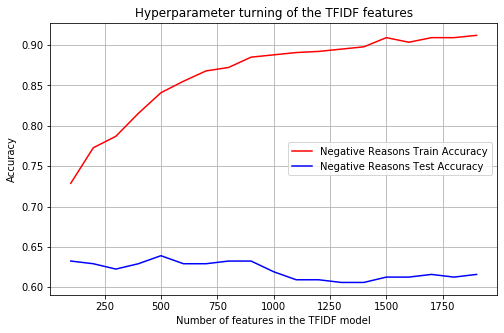

In [95]:
plt.figure(figsize=(8,5))
plt.plot(range(100,2000,100), accuracy_train, 'r')
plt.plot(range(100,2000,100), accuracy_test, 'b')

plt.grid()
plt.xlabel("Number of features in the TFIDF model")
plt.title("Hyperparameter turning of the TFIDF features")
plt.ylabel("Accuracy")
plt.legend(["Negative Reasons Train Accuracy", "Negative Reasons Test Accuracy"])
plt.show()

As suspected, the train accuracy goes up as the number of features increases. 200 features seem to be a good option in this case as it gives the highest test accuracy and the model is not overfitting. As the number of features increases, the model training accuracy increases and the test accuracy reduces.

## 5.0- Model Results

This section contains the responses to the statements in the assignment. They are being supported with the results from the earlier section.

### 5.1-Assignment statement:
Train models on the training data and apply the model to the test data to obtain an accuracy value. Evaluate the same model with best performance on the 2019 Canadian elections data. How well do your predictions match the sentiment labelled in the 2019 Canadian elections data?

Choose the model that has the best performance and visualize the sentiment prediction results and the true sentiment for each of the 3 parties. Compare your modeling results with election outcome.

To answer this question, lets look at the confusion matrix of the model predictions (using Logistic Regression) on the elections data:

In [96]:
#Using the same code used earlier to get the predictions for the election tweets.
X= df_generic['text'] #generic tweets
y= LabelEncoder().fit_transform(df_generic['class']) #to have targets as 0 and 1 as oppossed to 0 and 4

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

X_elections= df_elections["text"] #Canadian election tweets
y_elections= LabelEncoder().fit_transform(df_elections['sentiment']) #to have targets as 0 and 1 as oppossed to positive or negative

tfidf_vectorizer = TfidfVectorizer(stop_words = "english", max_df=0.7, max_features= 5500, ngram_range= (1,2))
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
X_elections_tfidf = tfidf_vectorizer.transform(X_elections)

model= LogisticRegression()
model.fit(tfidf_train,y_train) 

election_sentiment_predictions= model.predict(X_elections_tfidf) 
accuracy = metrics.accuracy_score(y_elections, election_sentiment_predictions)
print("Elections Sentiment Prediction Accuracy:", accuracy)

Elections Sentiment Prediction Accuracy: 0.5996249413970933


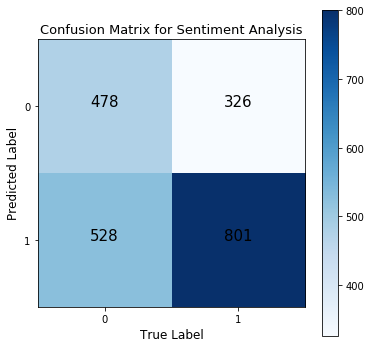

In [97]:
#Lets create a confusion matrix to visualize the predictions
#defining the confusion matrix
cm = metrics.confusion_matrix(election_sentiment_predictions,y_elections, labels= np.unique(y))
cmDF = pd.DataFrame()

for i, row in enumerate(np.unique(y)):
    temp = {}
    for j, col in enumerate( np.unique(y)): 
        temp[col]=cm[i,j]
    cmDF = cmDF.append(pd.DataFrame.from_dict({row:temp}, orient='index'))

#Plotting the confusion matrix
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Sentiment Analysis', fontsize=13)
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y), fontsize=10)
plt.yticks(tick_marks, np.unique(y), fontsize=10)
plt.xlabel('True Label', fontsize=12)
plt.ylabel('Predicted Label', fontsize=12)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] < 0:
            color = 'white'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)
    

As it was seen from the bar plots in Section 4.3, the negative tweets have not been classified well. In this case, there are 528 instances of negative tweets classified as positive. There are also 326 instances of positive tweets classified as negative. This can be noticed from the comparison of the actual and model sentiment analysis done for each party in Section 2.2.

For example- Liberals had a similar count of positive and negative tweets. The model predicted a lot more positive tweets than negative tweets. This trend follows for the othe two parties as well. The negative tweets have mostly been classified as positive tweets.

There could be numerous reasons for this. Firstly, the generic tweets given to us are from 2009 whereas the elections data is from 2019. There are a lot more ways to express anger on the internet now which was not present a decade ago. Also, a lot of sentiment is expressed through emojis which was not considered for the models. There could also be a case of people being sarcastic which means the so labelled positive tweet could be a sarcastic one and it was actually negative.

In summary, the sentiment analysis prediction accuracy was 60%.

Logistic Regression using TF-IDF was the best model as discussed earlier. The number of TFIDF features had an impact on the errors and hence the hyperparameter turning was conducted to find the best features.

The predictions, although contains errors, provide useful information on how the three parties did.

Liberals: People tweeted the most regarding Liberals in general. There were more negative sentiments (in the actual model) but the number of positive tweets still majorly outweigh the positive tweets for the other parties. They gained a lot more traction on the internet and had more people talking about them. Its a good indication of why they won the elections.

Conservatives: Once again, the same trend of the model failing to classify the negative tweets properly. However, the actual positive tweets are still lower than that of the Liberals. This may not be the only reason for their unsuccessful campaign, but it could be used as an area for improvement. They are seen as negative in the eyes of the people on social media. It would be good for them to understand the reasons why and improve in this regards since the Liberals have them beat on this.

NDP: The model did a better job classifying the tweets for this party. However, the overall count of tweets are low. This means that NDP is not as discussed on the social media compared to the other two parties which give an insight to their popularity in the country. However, they are the only party amongst the three who have more positive tweets than negative ones. NDP could use this information to understand which locations they are not popular in and focus more on those regions.

The same comparison mentioned above was done using bar charts in the earlier sections.

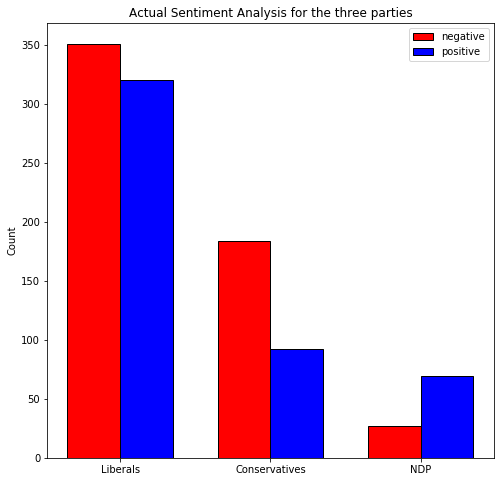

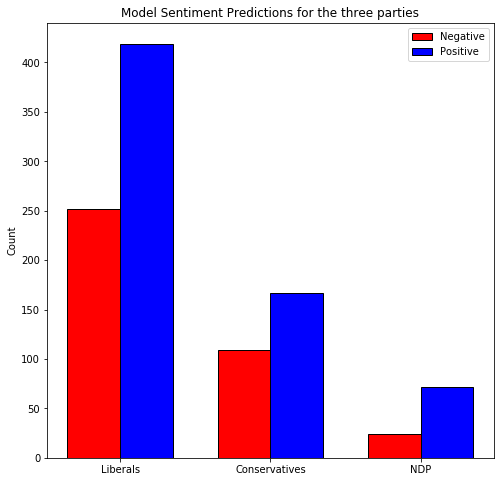

### 5.2- Assignment statement:
Discuss whether NLP analytics based on tweets is useful for political parties during election campaigns.

Sentiment analysis has been predominantly used in data science for analysis of customer feedbacks on products and reviews. They are used to understand user ratings on different kinds of products, hospitality services like travel, hotel bookings.

It can also be used to predict the sentiment for the tweets during election campaigns as it was in this case. These could be used to sense the mood of the public and understand areas for improvement for the political party. They could analyze the negative tweets and try to understand what is the reason behind the negative sentiments. Those negative reasons could be built (as it was in this case) for the tweets.
For example, Scandal and telling lies were the biggest reasons behind the negative tweets. There were various scandals flying around for the Liberal and Conservative party leader which is often the case during a closely fought election such as this one. This could be one of the major reasons that Liberals were not able to get majority in the government the way they did in the last term. This information could be useful as they can prioritize the issues during their election campaign. 

### 5.3- Assignment statement:
For the second model, based on the model that worked best, provide a few reasons why your model may fail to predict the correct negative reasons. Back up your reasoning with examples from the test sets.

Lets utilize the confusion matrix to answer this.

In [98]:
#Using the same code used earlier for the splitting of negative tweets
X= df_negative["text"]
y= df_negative["negative_reason"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

tfidf_vectorizer = TfidfVectorizer(stop_words = "english", max_df=0.7, max_features= 200, ngram_range= (1,2))
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

model= LogisticRegression(multi_class= 'multinomial', solver= "newton-cg")
model.fit(tfidf_train,y_train)

train_predictions= model.predict(tfidf_train)
test_predictions= model.predict(tfidf_test)

accuracy_train = metrics.accuracy_score(y_train, train_predictions)
accuracy_test= metrics.accuracy_score(y_test, test_predictions)

print("Train Set Accuracy:", accuracy_train)
print("Test Set Accuracy:", accuracy_test)

Train Set Accuracy: 0.7727272727272727
Test Set Accuracy: 0.6291390728476821


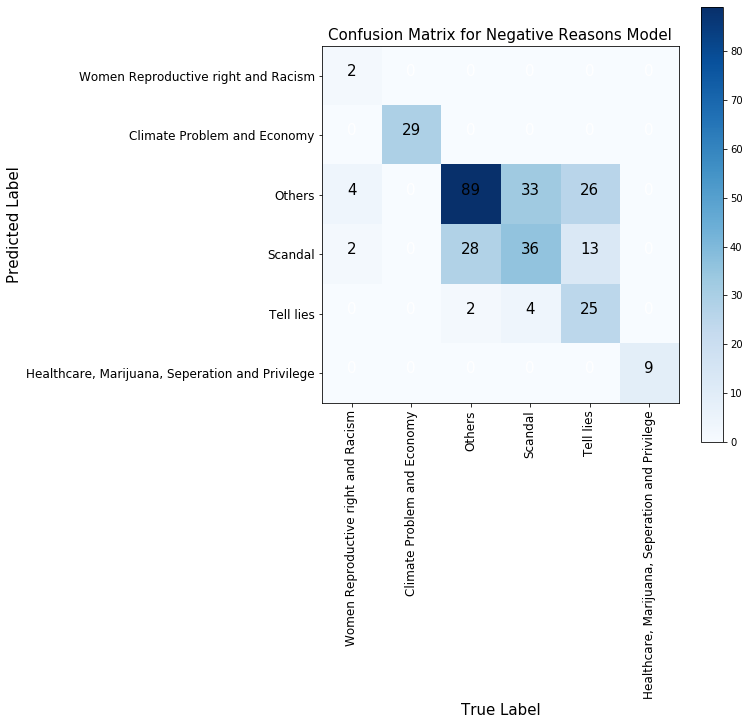

In [99]:
#defining the confusion matrix

cm = metrics.confusion_matrix(test_predictions,y_test, labels= y.unique())
cmDF = pd.DataFrame()

for i, row in enumerate(y.unique()):
    temp = {}
    for j, col in enumerate(y.unique()): 
        temp[col]=cm[i,j]
    cmDF = cmDF.append(pd.DataFrame.from_dict({row:temp}, orient='index'))


plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Negative Reasons Model', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(y.unique()))
plt.xticks(tick_marks, y.unique(), rotation=90,fontsize=12)
plt.yticks(tick_marks, y.unique(), fontsize=12)
plt.xlabel('True Label', fontsize=15)
plt.ylabel('Predicted Label', fontsize=15)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] < 1:
            color = 'white'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)

The majority of the data is being classified in Others, Scandal or Tell lies since they have majority of the data and are creating a strong bias in the model. In addition, Scandal and Tell lies could contain words that are similar and hence they could be mixed with each other when the model attempts to predict.

The Other group is too dominating and it should not be the case. There could be more options to extract more reasons out of them since the "others" does not give any great insight to work on.

For trial purposes, I combined the Scandal and Tell lies in one group and the model accuracy went upto 90%. However, that meant that predictions were majorly being made for only two groups and there is where 85% of the data is available. Accuracy is not a great measure when the data is unbalanced. The confusion matrix allows us to understand the precision and recall, i.e. how many times were the predicted and true labels the same.

There was only 18% of data available for the categories outside the top 3 and that is why the model failed to predict those properly. Grouping some of them together increased the model accuracy, however, the issues with the top 3 are still visible.

### 5.4- Assignment statement:
For both models, suggest one way you can improve the accuracy of your models.

Sentiment Predictions model accuracy could be increased by:
- Generic tweets should be upto date to capture the recent trends of how people express their sentiment.
- Using the emojis to be translated into words that would help capture sentiment.
- Hyperparameter tuning for the different models using cross validation.

Negative reasons model accuracy could be increased by:
- Having more data for the different categories to create a more balanced dataset. For example, having more data rather than just "Others" since Others itself is a huge group. There could be more reasons to extract from that group.
- The accuracy could simply be increased by grouping Scandal and Tell lies (upto 90%) but that would mean the top 2 categories holds around 85% of the data. This would fail to capture the rest of categories.
- Hyperparameter tuning for the different models using cross validation.

# Bonus- Deep learning implementation

This section was done as practice to implement Neural Networks onto a problem and compare the results for this to the results obtained from Logistic Regression (for both Sentiment Prediction and Negative Reason Classification.
Since Neural Networks take a long time to train usually, this was run on a smaller scale to understand how it works for different cases.

First things first, lets install and import required libraries.

In [100]:
!pip install keras

In [101]:
from keras import layers
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

Using TensorFlow backend.


Keras is a deep learning and neural networks API by François Chollet which is capable of running on top of Tensorflow (Google), Theano or CNTK (Microsoft).

The Sequential model is a linear stack of layers, where you can use the large variety of available layers in Keras. The most common layer is the Dense layer which is your regular densely connected neural network layer with all the weights and biases. Link: https://realpython.com/python-keras-text-classification/

This little helper function to visualize the loss and accuracy for the training and testing data based on the History callback. This callback, which is automatically applied to each Keras model, records the loss and additional metrics that can be added in the .fit() method. In this case, we are only interested in the accuracy. This helper function employs the matplotlib plotting library. This was taken from the website above to visualize the results.

In [102]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Word embedding methods are used here. This method represents words as dense word vectors (also called word embeddings) which are trained unlike the one-hot encoding which are hardcoded. This means that the word embeddings collect more information into fewer dimensions.

Note that the word embeddings do not understand the text as a human would, but they rather map the statistical structure of the language used in the corpus. Their aim is to map semantic meaning into a geometric space. This geometric space is then called the embedding space.

This would map semantically similar words close on the embedding space like numbers or colors. If the embedding captures the relationship between words well, things like vector arithmetic should become possible. A famous example in this field of study is the ability to map King - Man + Woman = Queen.

Keras offers an Embedding layer that can be used for neural networks on text data.
It requires that the input data be integer encoded, so that each word is represented by a unique integer. This data preparation step can be performed using the Tokenizer API also provided with Keras.
The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset.

In [103]:
#Recalling our generic tweets and elections tweets
X= df_generic['text'] #generic tweets
y= LabelEncoder().fit_transform(df_generic['class']) #to have targets as 0 and 1 as oppossed to 0 and 4

X_elections= df_elections["text"] #Canadian election tweets
y_elections= LabelEncoder().fit_transform(df_elections['sentiment']) #to have targets as 0 and 1 as oppossed to positive or negative

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [105]:
#Using the Keras tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_elections= tokenizer.texts_to_sequences(X_elections)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_elections= pad_sequences(X_elections, padding='post', maxlen=maxlen)

We will implement a Neural Network and train it for the generic tweets data.

In [106]:
embedding_dim = 50 #this affects the numbers of parameters you will have. potential parameter that could be tuned

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen)) #Embedding layer
model.add(layers.Flatten()) 
model.add(layers.Dense(10, activation='relu')) #First layer
model.add(layers.Dense(1, activation='sigmoid')) #Output layer. Binary classification mentioned here
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           3216850   
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 3,266,871
Trainable params: 3,266,871
Non-trainable params: 0
_________________________________________________________________


Train on 140000 samples, validate on 60000 samples
Epoch 1/10
140000/140000 [==============================] - 108s 775us/step - loss: 0.5268 - accuracy: 0.7363 - val_loss: 0.4940 - val_accuracy: 0.7621
Epoch 2/10
140000/140000 [==============================] - 109s 781us/step - loss: 0.4680 - accuracy: 0.7789 - val_loss: 0.4956 - val_accuracy: 0.7613
Epoch 3/10
140000/140000 [==============================] - 107s 767us/step - loss: 0.4330 - accuracy: 0.7993 - val_loss: 0.5056 - val_accuracy: 0.7544
Epoch 4/10
140000/140000 [==============================] - 109s 779us/step - loss: 0.3946 - accuracy: 0.8217 - val_loss: 0.5448 - val_accuracy: 0.7469
Epoch 5/10
140000/140000 [==============================] - 109s 776us/step - loss: 0.3599 - accuracy: 0.8405 - val_loss: 0.5852 - val_accuracy: 0.7381
Epoch 6/10
140000/140000 [==============================] - 110s 785us/step - loss: 0.3290 - accuracy: 0.8558 - val_loss: 0.6307 - val_accuracy: 0.7351
Epoch 7/10
140000/140000 [===========

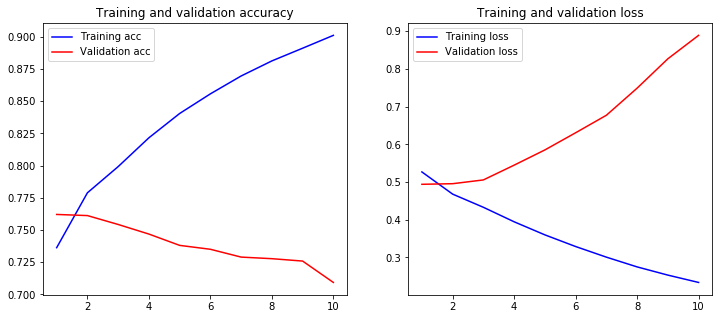

In [107]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=100) #number of epochs and batch size can be played with to reduce training time
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history) #Using the in-built function to see the performance of the model

In [108]:
loss, accuracy = model.evaluate(X_elections, y_elections, verbose=False)
print("Election Sentiment Accuracy:  {:.4f}".format(accuracy))

Election Sentiment Accuracy:  0.5799


The model starts overfitting as the number of epochs increases. This starts affecting the test accuracy as well as it reduces.
The accuracy result for the election tweets are not too different from what we obtained for Logistic Regression. Let's see if Convulational Neural Networks (CNNs) can provide better results.

CNNs are basically just several layers of convolutions with nonlinear activation functions like ReLU or tanh (sigmoid) applied to the results. In a traditional feedforward neural network we connect each input neuron to each output neuron in the next layer. That’s also called a fully connected layer, or affine layer. In CNNs we don’t do that. Instead, we use convolutions over the input layer to compute the output. This results in local connections, where each region of the input is connected to a neuron in the output. 

In [109]:
embedding_dim = 50 #same as last time

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen)) #embedding layer
model.add(layers.Conv1D(128, 5, activation='relu')) #convulational layer
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           3216850   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           32128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 3,250,279
Trainable params: 3,250,279
Non-trainable params: 0
_________________________________________________________________


Train on 140000 samples, validate on 60000 samples
Epoch 1/10
140000/140000 [==============================] - 157s 1ms/step - loss: 0.5096 - accuracy: 0.7454 - val_loss: 0.4912 - val_accuracy: 0.7611
Epoch 2/10
140000/140000 [==============================] - 158s 1ms/step - loss: 0.4520 - accuracy: 0.7868 - val_loss: 0.4882 - val_accuracy: 0.7630
Epoch 3/10
140000/140000 [==============================] - 158s 1ms/step - loss: 0.4030 - accuracy: 0.8167 - val_loss: 0.5084 - val_accuracy: 0.7568
Epoch 4/10
140000/140000 [==============================] - 158s 1ms/step - loss: 0.3423 - accuracy: 0.8509 - val_loss: 0.5663 - val_accuracy: 0.7451
Epoch 5/10
140000/140000 [==============================] - 158s 1ms/step - loss: 0.2767 - accuracy: 0.8845 - val_loss: 0.6428 - val_accuracy: 0.7406
Epoch 6/10
140000/140000 [==============================] - 163s 1ms/step - loss: 0.2189 - accuracy: 0.9107 - val_loss: 0.7698 - val_accuracy: 0.7321
Epoch 7/10
140000/140000 [=======================

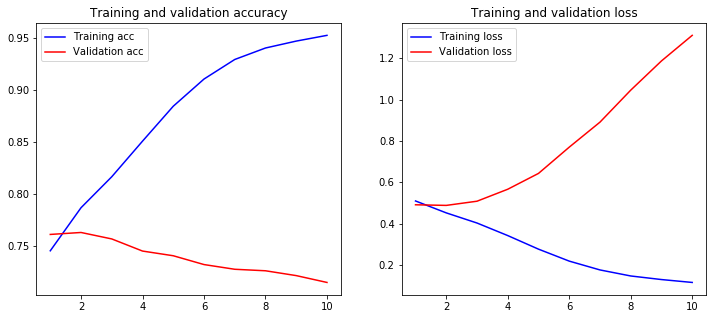

In [110]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=100)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [111]:
loss, accuracy = model.evaluate(X_elections, y_elections, verbose=False)
print("Election Sentiment Accuracy:  {:.4f}".format(accuracy))

Election Sentiment Accuracy:  0.5743


CNN does a better job than the basic neural network (for some runs), however, the accuracy still has not increased by a great margin. Logistic Regression produced a similar accuracy.

THe model is once again overfitting as the number of epochs increases.

Lets do CNN for the negative reasons classification

In [112]:
#Recalling our negative reasons data
X= df_negative["text"]
y= df_negative["negative_reason"]

In [113]:
y_onehot= pd.get_dummies(y) #We need to one hot encode the targets to use softmax 

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.3, random_state = 42)

In [115]:
#Using the Keras embedding feature
tokenizer = Tokenizer(num_words=500)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [116]:
embedding_dim = 200

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen)) 
model.add(layers.Conv1D(128, 5, activation='relu')) #CNN layer
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(6, activation='softmax')) #softmax is now being used instead of sigmoid since its categorical classification. The layers are 6 since there are 6 outputs
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) #Note that it is now categorial and no longer binry classification
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 200)          716600    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 128)           128128    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                2580      
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 126       
Total params: 847,434
Trainable params: 847,434
Non-trainable params: 0
_________________________________________________________________


Train on 704 samples, validate on 302 samples
Epoch 1/20
704/704 [==============================] - 2s 2ms/step - loss: 1.6746 - accuracy: 0.3253 - val_loss: 1.5458 - val_accuracy: 0.5596
Epoch 2/20
704/704 [==============================] - 1s 2ms/step - loss: 1.2860 - accuracy: 0.5653 - val_loss: 1.1246 - val_accuracy: 0.5629
Epoch 3/20
704/704 [==============================] - 1s 2ms/step - loss: 0.8067 - accuracy: 0.7557 - val_loss: 0.8855 - val_accuracy: 0.6291
Epoch 4/20
704/704 [==============================] - 1s 2ms/step - loss: 0.5199 - accuracy: 0.8466 - val_loss: 0.9134 - val_accuracy: 0.6490
Epoch 5/20
704/704 [==============================] - 2s 2ms/step - loss: 0.3495 - accuracy: 0.8963 - val_loss: 0.9520 - val_accuracy: 0.6457
Epoch 6/20
704/704 [==============================] - 1s 2ms/step - loss: 0.2141 - accuracy: 0.9432 - val_loss: 1.0420 - val_accuracy: 0.6424
Epoch 7/20
704/704 [==============================] - 1s 2ms/step - loss: 0.1326 - accuracy: 0.9744 - 

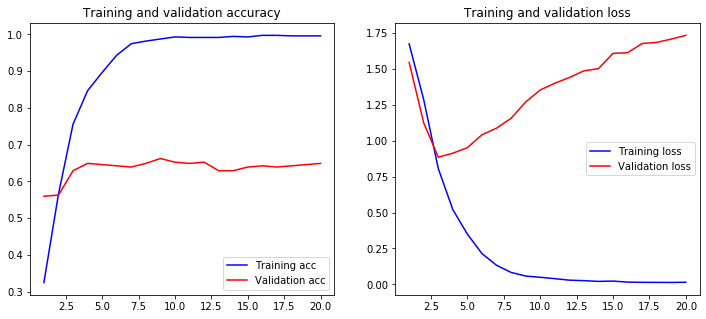

In [117]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=20)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

CNN does well in this case as the accuracy has been increased from 63% (earlier from Logistic Regression) to 65%.

There are a lot of further works that could be done using these Neural Networks to obtain better results, but this was just a highlight to understand how neural networks does on the models. It goes to show that sometimes the simple models are the better choices compared to models that are more complex and time consuming.

The results of the neural networks could potentially be increased using hyperparamter tuning or utilizing other ways on constructing the neural networks.